<a href="https://colab.research.google.com/github/willkakuta/Material_de_Aula/blob/main/ReviewClassificacaoDay09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contextualização

**Objetivo**

Classificar alimentos provenientes da agricultura conforme suas características.


**Dicionário dos dados**

| Coluna    | Descrição |
|----------:|----------:|
|N          |% de nitrogênio contido no solo|
|P          |% of fósforo contido no solo|
|K          |% of potásso contido no solo|
|temperature|Temperatura do local|
|humidity   |Umidade relativa|
|ph         |Ph do solo|
|rainfall   |Quantidade de chuva por mês em mm|
|label      |Alimento (coluna alvo)|

Fonte dos dados proveniente [deste link](https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset).

# SETUP

## Libraries

In [ ]:
%pip install lime
%pip install dtreeviz

In [ ]:
import lime.lime_tabular
from dtreeviz.trees import dtreeviz

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

## Custom functions

In [ ]:
def get_metrics(y_true, y_pred):
  target_metrics = {
      'accuracy': metrics.accuracy_score(y_true, y_pred),
      # 'balanced_accuracy': metrics.balanced_accuracy_score(y_true, y_pred),
      'precision': metrics.precision_score(y_true, y_pred, average='weighted'),
      'recall': metrics.recall_score(y_true, y_pred, average='weighted'),
      'f1': metrics.f1_score(y_true, y_pred, average='weighted')
  }
  return target_metrics

def evaluate_model_pipeline(model):
  model_pipeline = Pipeline(steps=[
      ('preprocessor', StandardScaler()),
      ('clf', model)
  ])
  
  model_pipeline.fit(X_train, y_train)
  
  ytrain_pred = model_pipeline.predict(X_train)
  ytest_pred = model_pipeline.predict(X_test)

  train_metrics = pd.Series(get_metrics(y_train, ytrain_pred))
  test_metrics = pd.Series(get_metrics(y_test, ytest_pred))
  train_test_metrics = pd.concat([
      train_metrics.to_frame('train'),
      test_metrics.to_frame('test')
  ], axis=1)
  
  return train_test_metrics

## Custom settings

In [ ]:
sns.set_theme(
  context='talk',
  style='ticks',
  font_scale=.75,
  rc={
      'axes.grid':True,
      'grid.alpha':.2,
      'figure.figsize':(12,8),
      'axes.titlepad': 20
  }
)

## Load dataset

In [ ]:
# Read data
DATA_URL = 'https://github.com/cmcouto-silva/datasets/raw/main/datasets/crop_recommendation.csv'
df = pd.read_csv(DATA_URL)

# Create a categorical column for didatic purpose
df['N_cat'] = pd.cut(df['N'], bins=12)

# Display data
display(df)

,N,P,K,temperature,humidity,ph,rainfall,label,N_cat
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,"(81.667, 93.333]"
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,"(81.667, 93.333]"
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,"(58.333, 70.0]"
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,"(70.0, 81.667]"
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,"(70.0, 81.667]"
...,...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee,"(105.0, 116.667]"
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee,"(93.333, 105.0]"
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee,"(116.667, 128.333]"
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee,"(116.667, 128.333]"


# EDA

### Overall EDA

In [ ]:
# Checking data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   N            2200 non-null   int64   
 1   P            2200 non-null   int64   
 2   K            2200 non-null   int64   
 3   temperature  2200 non-null   float64 
 4   humidity     2200 non-null   float64 
 5   ph           2200 non-null   float64 
 6   rainfall     2200 non-null   float64 
 7   label        2200 non-null   object  
 8   N_cat        2200 non-null   category
dtypes: category(1), float64(4), int64(3), object(1)
memory usage: 140.3+ KB


In [ ]:
# Checking missing values
df.isna().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
N_cat          0
dtype: int64

In [ ]:
# Checking duplicated rows
df.duplicated().any()

False

In [ ]:
# Unique labels
df.label.nunique()

22

In [ ]:
# Counts by label
df.label.value_counts()

rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: label, dtype: int64

In [ ]:
labels = df.label.sort_values().unique()
label_mapper = {label:i for i,label in enumerate(labels)}
label_mapper

{'apple': 0,
 'banana': 1,
 'blackgram': 2,
 'chickpea': 3,
 'coconut': 4,
 'coffee': 5,
 'cotton': 6,
 'grapes': 7,
 'jute': 8,
 'kidneybeans': 9,
 'lentil': 10,
 'maize': 11,
 'mango': 12,
 'mothbeans': 13,
 'mungbean': 14,
 'muskmelon': 15,
 'orange': 16,
 'papaya': 17,
 'pigeonpeas': 18,
 'pomegranate': 19,
 'rice': 20,
 'watermelon': 21}

### Multivariate Analysis

In [ ]:
numeric_features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
categorical_features = ['N_cat']

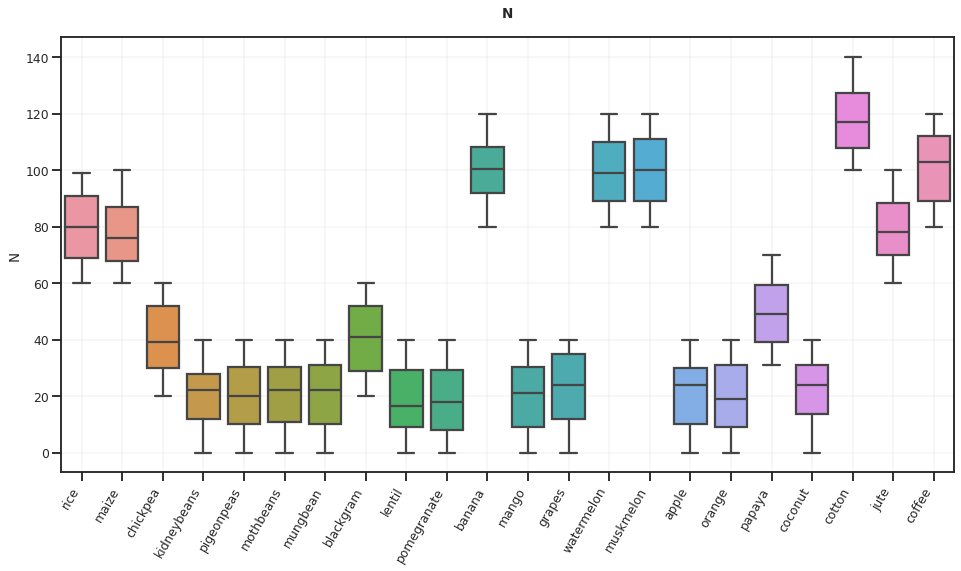

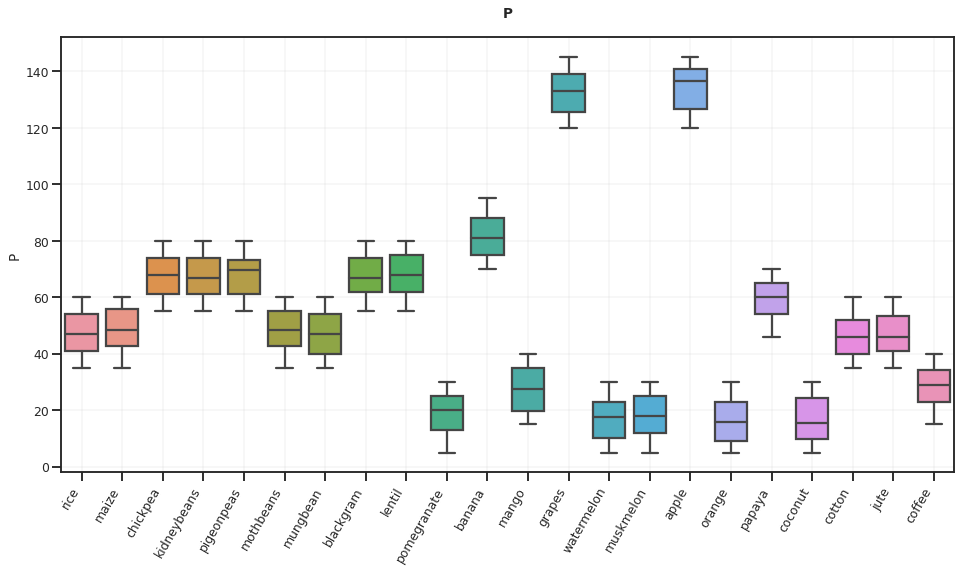

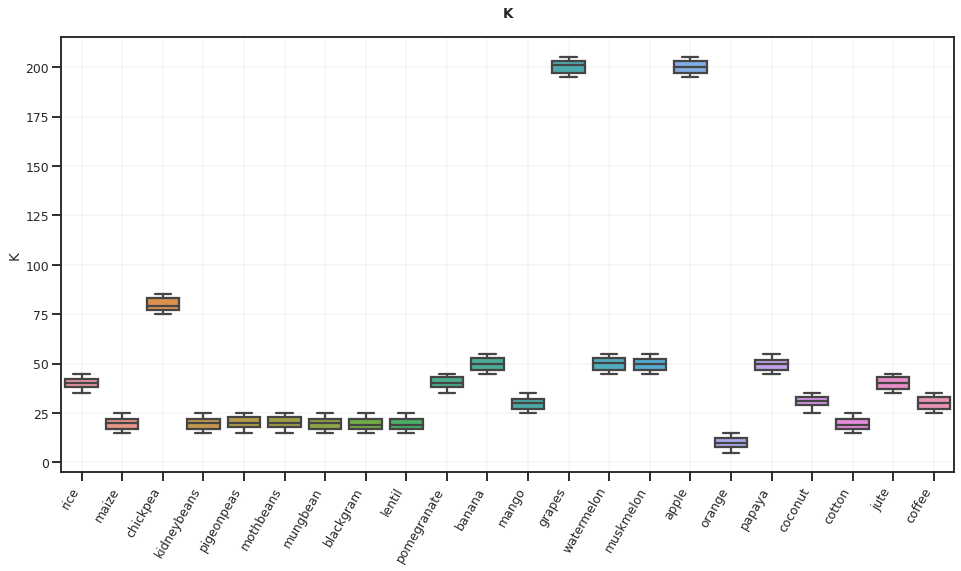

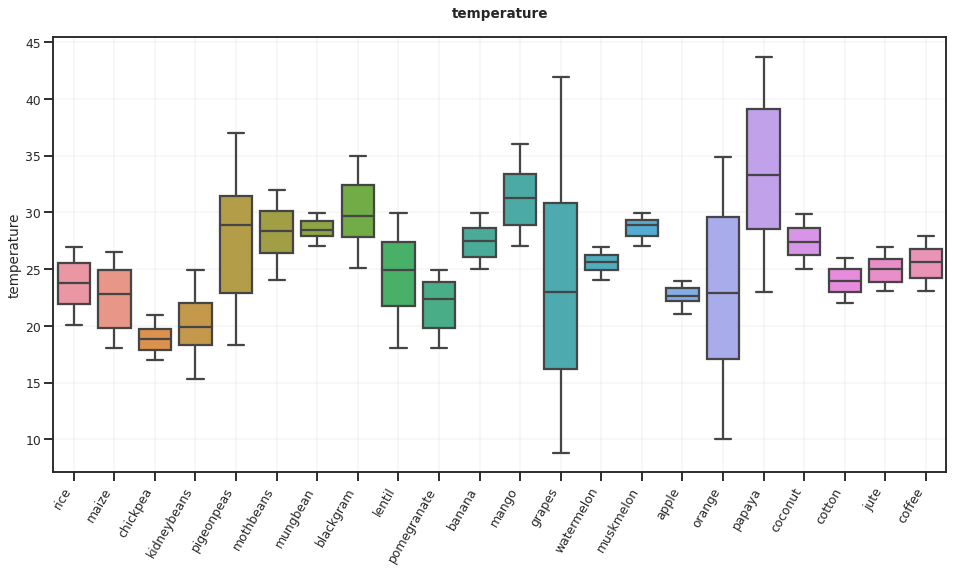

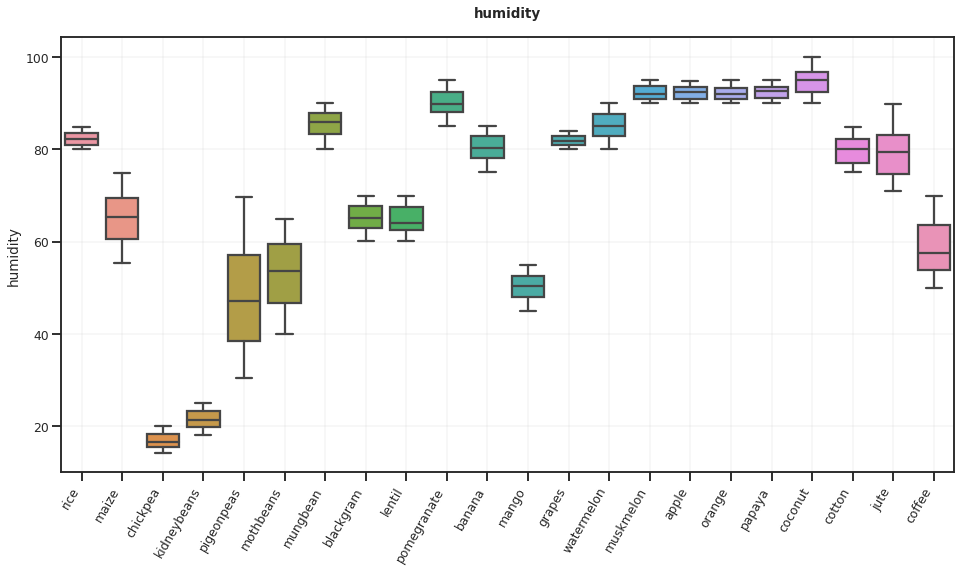

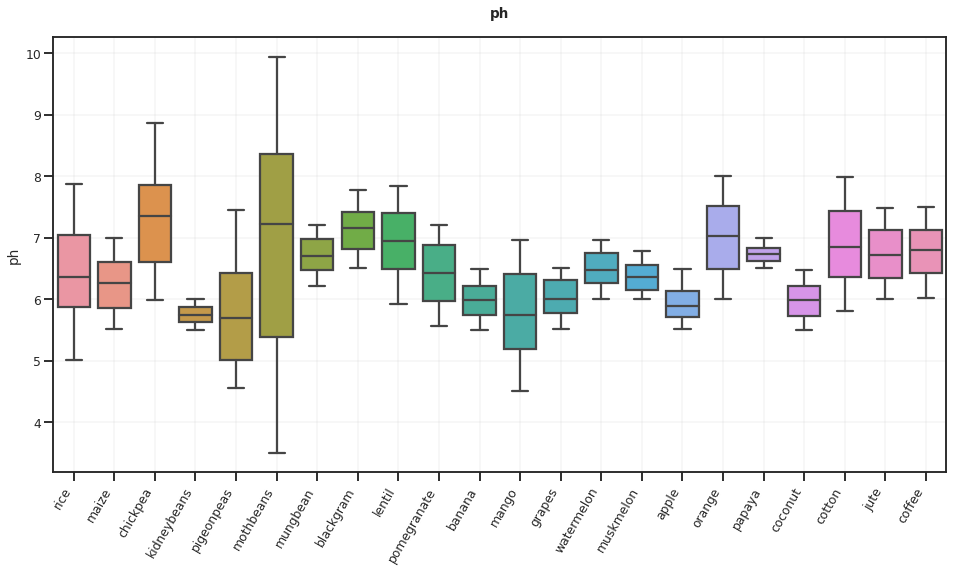

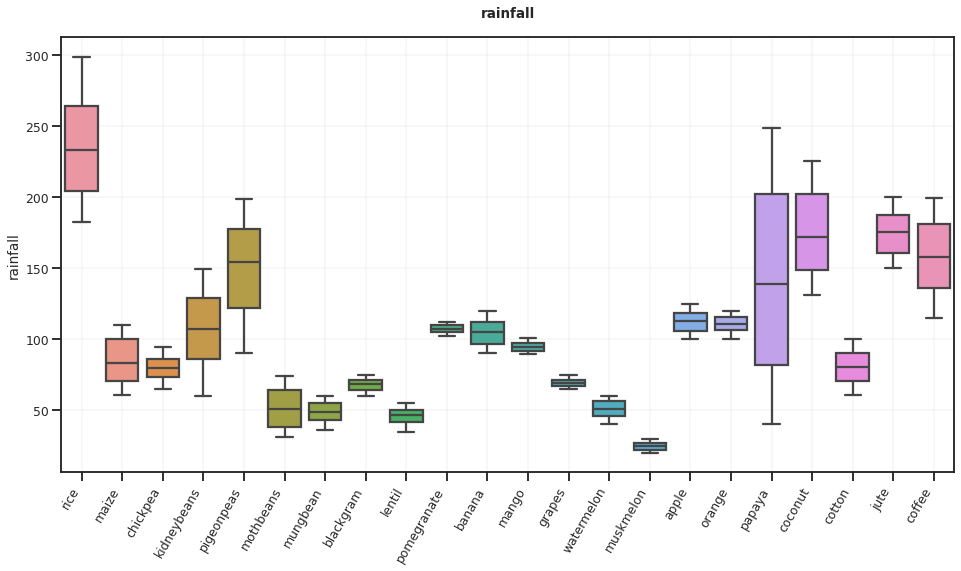

In [ ]:
for feature in numeric_features:
  plt.figure(figsize=(16,8))
  sns.boxplot(data=df, x='label', y=feature)
  plt.title(feature, weight='bold')
  plt.xticks(rotation=60, ha='right')
  plt.xlabel(None)
  plt.grid(True)
  plt.show()
  print()

In [ ]:
df_barplot = df.groupby(['label','N_cat'], as_index=False).size()
df_barplot['N_cat'] = df_barplot.N_cat.astype(str)

px.bar(df_barplot, x='N_cat', y='size', color='label') \
.update_yaxes(title='N category count') \
.update_xaxes(title='')


In [ ]:
px.scatter_3d(df, x='humidity', y='rainfall', z='temperature', color='label')

In [ ]:
px.scatter_3d(df, x='N', y='P', z='K', color='label')

# Modeling

In [ ]:
# features
numeric_features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
categorical_features = ['N_cat']

In [ ]:
# Split data into train and test
X = df[numeric_features].copy()
y = df['label'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123, stratify=y)

## Test models

In [ ]:
evaluate_model_pipeline(LogisticRegressionCV(max_iter=10_000))

,train,test
accuracy,0.992208,0.980303
precision,0.992239,0.980842
recall,0.992208,0.980303
f1,0.992206,0.980259


In [ ]:
def evaluate_model_pipeline(model):
  model_pipeline = Pipeline(steps=[
      ('preprocessor', StandardScaler()),
      ('clf', model)
  ])
  
  model_pipeline.fit(X_train, y_train)
  
  ytrain_pred = model_pipeline.predict(X_train)
  ytest_pred = model_pipeline.predict(X_test)

  train_metrics = pd.Series(get_metrics(y_train, ytrain_pred))
  test_metrics = pd.Series(get_metrics(y_test, ytest_pred))
  train_test_metrics = pd.concat([
      train_metrics.to_frame('train'),
      test_metrics.to_frame('test')
  ], axis=1)
  
  return train_test_metrics

In [ ]:
evaluate_model_pipeline(KNeighborsClassifier())

,train,test
accuracy,0.979221,0.971212
precision,0.980770,0.974227
recall,0.979221,0.971212
f1,0.979197,0.970966


In [ ]:
evaluate_model_pipeline(RandomForestClassifier())

,train,test
accuracy,1.0,0.995455
precision,1.0,0.995868
recall,1.0,0.995455
f1,1.0,0.995443


## Tune model

In [ ]:
model_pipeline = Pipeline(steps=[
    ('preprocessing', StandardScaler()),
    ('clf', KNeighborsClassifier())
])

param_grid = {
    'clf__n_neighbors': range(2,21)
}

grid_model = GridSearchCV(model_pipeline, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_model.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing', StandardScaler()),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=-1, param_grid={'clf__n_neighbors': range(2, 21)},
             scoring='f1_weighted')

In [ ]:
print(f"""
Best score: {grid_model.best_score_}
Best K: {grid_model.best_params_}
""")


Best score: 0.9703723046557768
Best K: {'clf__n_neighbors': 3}



In [ ]:
y_pred = grid_model.predict(X_test)
get_metrics(y_test, y_pred)

{'accuracy': 0.9924242424242424,
 'precision': 0.99270496258469,
 'recall': 0.9924242424242424,
 'f1': 0.992470212074224}

In [ ]:
#heatmap

## Visual Model Evaluation

### Lime

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestClassifier(max_depth=10)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10)

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=numeric_features,
    class_names=labels
)

In [ ]:
explainer_instance = explainer.explain_instance(
    X_test_scaled[1],
    rf.predict_proba,
    num_features=6,
    top_labels=1
)

explainer_instance.show_in_notebook()

### DtreeViz

In [ ]:
# Select target labels
target_labels = [
 'rice',
 'maize',
 'chickpea',
 'kidneybeans',
 'pigeonpeas',
 'mothbeans',
 'mungbean'
]

# Filter data
df_sample = df.query('label in @target_labels')

In [ ]:
# Split data into train and test
X = df_sample[numeric_features].copy()
y = df_sample['label'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123, stratify=y)

In [ ]:
# Encode target 
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
# Train a simple decision tree model
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



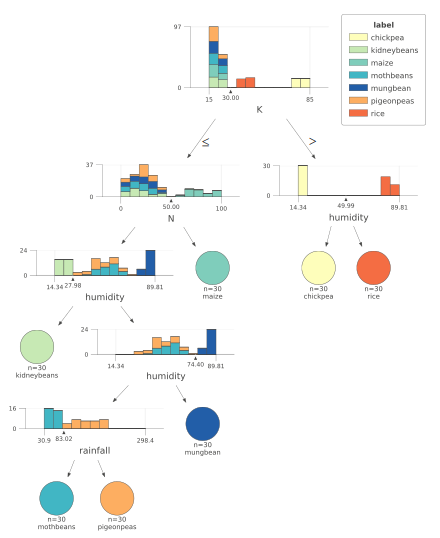

In [ ]:
# Make visualization
dtreeviz(
  tree_model=dt,
  x_data=X_test,
  y_data=y_test,
  target_name='label',
  feature_names=numeric_features,
  class_names=list(le.classes_)
)